In [7]:
!pip install utils

In [39]:
import cv2
import numpy as npa
from utils import *
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model

## Helper Functions

In [9]:
#Stacks the images in one image
def stackImages(imgArray,scale):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
            hor_con[x] = np.concatenate(imgArray[x])
        ver = np.vstack(hor)
        ver_con = np.concatenate(hor)
    else:
        for x in range(0, rows):
            imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        hor_con= np.concatenate(imgArray)
        ver = hor
    return ver

In [10]:
#Biggest Contour Finder
def biggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        peri = cv2.arcLength(i, True)
        approx = cv2.approxPolyDP(i, 0.02 * peri, True)
        if area > max_area and len(approx) == 4:
            biggest = approx
            max_area = area
    return biggest,max_area

In [11]:
#Reordering the contour points as (top-lh corner, top-rh corner, bottom-lh corner, bottom-rh corner)
def reorder(contourPoints):
    contourPoints = contourPoints.reshape((4, 2))
    contourPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = contourPoints.sum(1)
    contourPointsNew[0] = contourPoints[np.argmin(add)]
    contourPointsNew[3] = contourPoints[np.argmax(add)]
    diff = np.diff(contourPoints, axis=1)
    contourPointsNew[1] = contourPoints[np.argmin(diff)]
    contourPointsNew[2] = contourPoints[np.argmax(diff)]
    return contourPointsNew

In [241]:
#Displaying the digits extracted
def displayNumbers(img,numbers,color = (0,255,0)):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for x in range (0,9):
        for y in range (0,9):
            if numbers[(y*9)+x] != 0 :
                 cv2.putText(img, str(numbers[(y*9)+x]),
                               (x*secW+int(secW/2)-10, int((y+0.8)*secH)), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                            2, color, 2, cv2.LINE_AA)
    return img

In [245]:
"""
This module finds the solution of a given sudoku problem
Code credits: Tim Ruscica
More info: https://techwithtim.net/tutorials/python-programming/sudoku-solver-backtracking/
Example input board
board = [
    [7,8,0,4,0,0,1,2,0],
    [6,0,0,0,7,5,0,0,9],
    [0,0,0,6,0,1,0,7,8],
    [0,0,7,0,4,0,2,6,0],
    [0,0,1,0,5,0,9,3,0],
    [9,0,4,0,6,0,0,0,5],
    [0,7,0,3,0,0,0,1,2],
    [1,2,0,0,0,7,4,0,0],
    [0,4,9,2,0,6,0,0,7]
]
"""

def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find
    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i
            if solve(bo):
                return True
            bo[row][col] = 0
    return False

def valid(bo, num, pos):
    # Check row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False
    # Check column
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False
    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3
    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False
    return True

def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")
        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")
            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end="")

def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)  # row, col
    return None

## Main

In [265]:
imgPath = '/content/drive/MyDrive/Sudoku Solver/sudoku2.png'
imgHeight = 450
imgWidth = 450

In [267]:
img = cv2.imread(imgPath)
img = cv2.resize(img, (imgWidth, imgHeight))

blankImg = np.zeros_like(img)

### Image Preprocessing

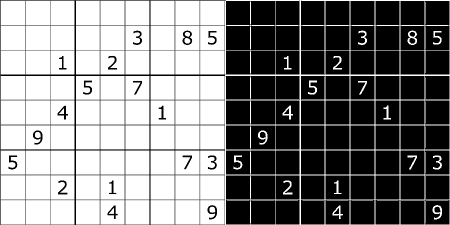

-1

In [268]:
def preprocessing(img):
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 3)
    imgThreshold = cv2.adaptiveThreshold(imgGray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 3)
    return(imgThreshold)

preprocessedImg = preprocessing(img)
imgArray = ([img, preprocessedImg])
stackedImg = stackImages(imgArray, 0.5)
#cv2.imshow('Images', stackedImg)
cv2_imshow(stackedImg)
cv2.waitKey(0)

### Finding Contours

In [269]:
imgContour = img.copy()
contours, hierarchy = cv2.findContours(preprocessedImg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(imgContour, contours, -1, (0,0,255), 2)

imgArray = ([img, imgContour])
stackedImg = stackImages(imgArray, 0.5)
#cv2.imshow('Contours', stackedImg)
cv2.waitKey(0)

-1

### Biggest Contour wrt Area

In [270]:
bigImgContour = img.copy()
points, area = biggestContour(contours)
reorderedPoints = reorder(points)
cv2.drawContours(bigImgContour, reorderedPoints, -1, (0,0,255), 10)

#cv2.imshow('Biggest Contour', bigImgContour)
cv2.waitKey(0)

-1

### Warp perspective 

In [271]:
p1 = np.float32(reorderedPoints)
p2 = np.float32([[0, 0], [imgWidth, 0], [0, imgHeight], [imgWidth, imgHeight]])
matrix = cv2.getPerspectiveTransform(p1, p2)
imgWarpCol = cv2.warpPerspective(img, matrix, (imgWidth, imgHeight))
imgWarpGray = cv2.cvtColor(imgWarpCol, cv2.COLOR_BGR2GRAY)
#cv2.imshow('Warp Perspective', imgWarp)

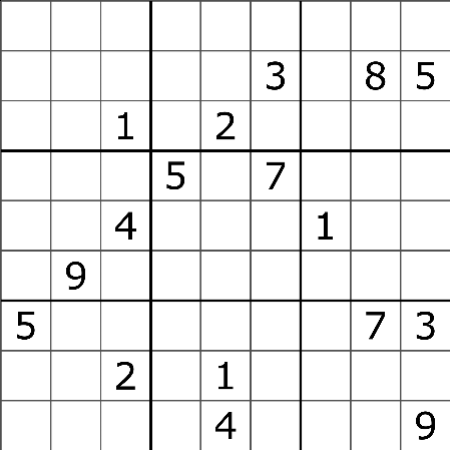

In [272]:
cv2_imshow(imgWarpGray)

### Dividing the image into 81 images

In [273]:
def splitImage(img):
  rows = np.vsplit(img, 9)
  cells = []
  for row in rows:
    boxes = np.hsplit(row, 9)
    for box in boxes:
      cells.append(box)
  return cells

indivBoxes = splitImage(imgWarpGray)

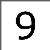

In [274]:
#cv2.imshow('Sample Image', indivBoxes)
cv2_imshow(indivBoxes[80])

### Predicting the value of images

In [275]:
model = load_model('/content/drive/MyDrive/Sudoku Solver/test_model.h5')

In [276]:
def getPredection(boxes,model):
    result = []
    for image in boxes:
        img = image
        img = img[5:img.shape[0] - 5, 5:img.shape[1] -5]
        ret, img = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV) 
        img = cv2.resize(img, (28,28))
        #img = ~img
        img = img.reshape(1, 28, 28, 1)
        #img = img/255
        ## GET PREDICTION
        prediction = model.predict(img)
        res = prediction.argmax()
        ## SAVE TO RESULT
        if prediction.max() > 0.80:
            result.append(res)
        else:
            result.append(0)
    return result

res = getPredection(indivBoxes,model)

### Displaying the digits

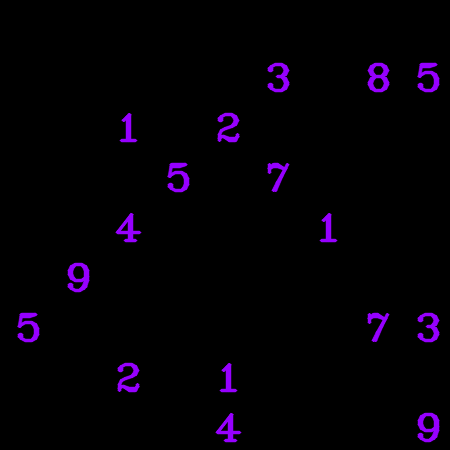

In [279]:
template = blankImg.copy()
imgDetectedDigits = displayNumbers(template, res, color=(255, 0, 150))
#cv2.imread('Image Numbers', imgDetectedDigits)
cv2_imshow(imgDetectedDigits)

### Solving 

In [280]:
res = np.asarray(res)
posArray = np.where(res > 0, 0, 1)

[array([3, 5, 8, 4, 7, 6, 2, 9, 1]), array([4, 2, 7, 1, 9, 3, 6, 8, 5]), array([9, 6, 1, 8, 2, 5, 3, 4, 7]), array([1, 3, 6, 5, 8, 7, 9, 2, 4]), array([8, 7, 4, 2, 3, 9, 1, 5, 6]), array([2, 9, 5, 0, 0, 0, 0, 0, 0]), array([5, 0, 0, 0, 0, 0, 0, 7, 3]), array([0, 0, 2, 0, 1, 0, 0, 0, 0]), array([0, 0, 0, 0, 4, 0, 0, 0, 9])]


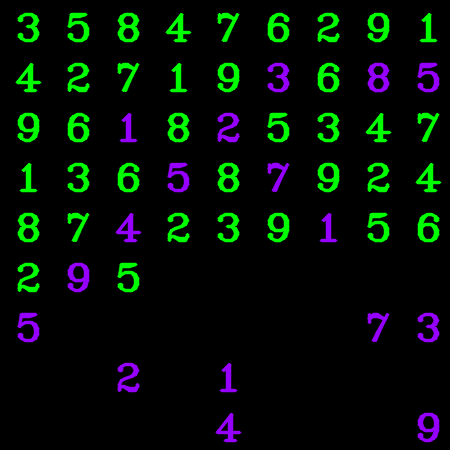

In [281]:
board = np.array_split(res,9)
try:
    solve(board)
except:
    pass
print(board)
flatList = []
for sublist in board:
    for item in sublist:
        flatList.append(item)
solvedNumbers =flatList*posArray
imgSolvedDigits = displayNumbers(template, solvedNumbers)
#cv2.imread('Image Numbers', imgSolvedDigits)
cv2_imshow(imgSolvedDigits)

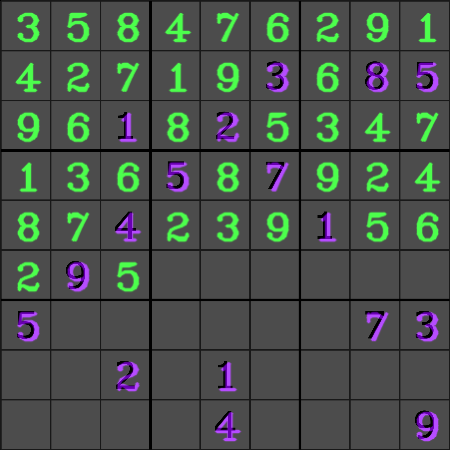

In [283]:
p2 = np.float32(reorderedPoints) # PREPARE POINTS FOR WARP
p1 =  np.float32([[0, 0], [imgWidth, 0], [0, imgHeight], [imgWidth, imgHeight]]) # PREPARE POINTS FOR WARP
matrix = cv2.getPerspectiveTransform(p1, p2)  # GER
imgInvWarpColored = img.copy()
imgInvWarpColored = cv2.warpPerspective(imgSolvedDigits, matrix, (imgWidth, imgHeight))
inv_perspective = cv2.addWeighted(imgInvWarpColored, 0.7, img, 0.3, 0)

cv2_imshow(inv_perspective)